In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
import numpy as np 
import pandas as pd 
import gzip
import os
import cv2
import random

In [0]:
import glob
from sklearn.model_selection import train_test_split

Path = '/content/drive/My Drive/Project/'
train = sorted(glob.glob(Path + 'train/*.jpg'))
test  = sorted(glob.glob(Path + 'test/*.jpg'))
masks = sorted(glob.glob(Path + 'train_masks/*.gif'))
meta = pd.read_csv(Path + 'metadata.csv')
mask_df = pd.read_csv(Path + 'train_masks.csv')

#80/20 training
train_images, test_images = train_test_split(train, train_size=0.8, test_size=0.2)

Choosen image to test data pull of train images:


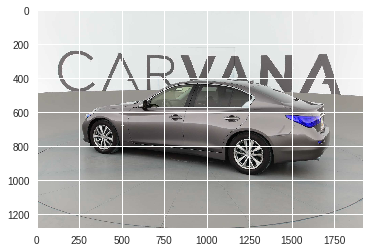

Choosen image to test data pull of mask images:


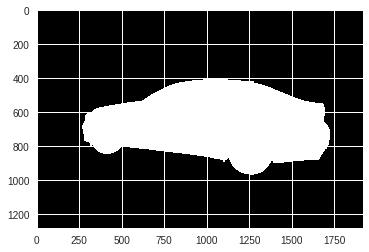

In [18]:
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

print('Choosen image to test data pull of train images:')
image = cv2.imread(Path + 'train/0ee135a3cccc_06.jpg')
plt.imshow(image)
plt.show()

print('Choosen image to test data pull of mask images:')
img = Image.open(Path + 'train_masks/0ee135a3cccc_06_mask.gif')
plt.imshow(img)
plt.show()




In [0]:
from scipy.misc import imresize
from skimage.transform import resize
from os.path import basename

size = [128,128]
def transform(img):
    color_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            color_img.append(list(img[i][j])*3)
    color_img = np.array(color_img).reshape(img.shape[0], img.shape[1], 3)
    return color_img

def data_gen_small(data_dir, masks, images, batch_size, size):
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                original_img = cv2.imread(images[i])
                resized_img = imresize(original_img, size+[3]) 
                array_img = resized_img / 255   
                array_img = array_img.swapaxes(0,2)
                imgs.append(array_img)
                
                mask_filename = basename(images[i])
                no_extension = os.path.splitext(mask_filename)[0]
                correct_mask = Path + 'train_masks/' + no_extension + '_mask.gif' 
                original_mask = Image.open(correct_mask).convert('L')
                data = np.asarray( original_mask, dtype="int32" )
                resized_mask = imresize(original_mask, size+[3])
                array_mask = resized_mask / 255
                labels.append(array_mask)
            imgs = np.array(imgs)
            labels = np.array(labels)
            relabel = labels.reshape(-1, 128, 128, 1)
            yield imgs, relabel.swapaxes(1, 3)

In [20]:
trainer = data_gen_small(Path + 'train/', masks, train_images, 2, size) 
img, msk = next(trainer)
newshape = img[0].swapaxes(0,2)
resized_img = imresize(img[0], [1280, 1918]+[3])
newshape = resized_img.swapaxes(0,1)
newshape = msk.swapaxes(1,3)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [0]:
a='validation'
b='valid'
c='predictor'
d='predict'

def dice_coef(b, d):
    a = K.flatten(b)
    c = K.flatten(d)
    intersection = K.sum(a * c)
    return (2. * intersection + 1.) / (K.sum(a) + K.sum(c) + 1.)

def dice_coef_np(b,d):
    a = b.flatten()
    c = d.flatten()
    intersection = np.sum(a * c)
    return (2. * intersection + 1.) / (np.sum(a) + np.sum(c) + 1.)

def dice_coef_loss(b, d):
    return -dice_coef(b, d)

In [0]:
tester = data_gen_small(Path + 'train/', masks, test_images, 4, size) 

Model Run with 50 iteration, 30 epochs, and learning rate of .0005. U-net has 4 layers starting at 32 filters and exponetially increasing by 2 (ie. X^2, (X+1)^2, ... (X+n)^2) up to 512.

In [36]:
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.optimizers import Adam
from keras import backend as K
K.set_image_dim_ordering('th')

def unet_car_segmentation():
    inputs = Input((3,size[0], size[1]))
    
    level1 = Conv2D(32, (3, 3), padding= "same", activation='relu')(inputs)    
    level1 = Conv2D(32, (3, 3), padding= "same", activation='relu')(level1)
    maxpool1 = MaxPooling2D(pool_size=(2, 2))(level1)

    level2 = Conv2D(64, (3, 3), padding="same", activation='relu')(maxpool1)
    level2 = Conv2D(64, (3, 3), padding="same", activation='relu')(level2)    
    maxpool2 = MaxPooling2D(pool_size=(2, 2))(level2)

    level3 = Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool2)
    level3 = Conv2D(128, (3, 3), padding="same", activation='relu')(level3)
    maxpool3 = MaxPooling2D(pool_size=(2, 2))(level3)

    level4 = Conv2D(256, (3, 3), padding="same", activation='relu')(maxpool3)
    level4 = Conv2D(256, (3, 3), padding="same", activation='relu')(level4)
    maxpool4 = MaxPooling2D(pool_size=(2, 2))(level4)

    level5 = Conv2D(512, (3, 3), padding="same", activation='relu')(maxpool4)
    level5 = Conv2D(512, (3, 3), padding="same", activation='relu')(level5)

    upconv6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level5), level4])
    level6 = Conv2D(256, (3, 3), padding="same", activation='relu')(upconv6)
    level6 = Conv2D(256, (3, 3), padding="same", activation='relu')(level6)

    upconv7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level6), level3])
    level7 = Conv2D(128, (3, 3), padding="same", activation='relu')(upconv7)
    level7 = Conv2D(128, (3, 3), padding="same", activation='relu')(level7)

    upconv8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level7), level2])
    level8 = Conv2D(64, (3, 3), padding="same", activation='relu')(upconv8)
    level8 = Conv2D(64, (3, 3), padding="same", activation='relu')(level8)

    upconv9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level8), level1])
    level9 = Conv2D(32, (3, 3), padding="same", activation='relu')(upconv9)
    level9 = Conv2D(32, (3, 3), padding="same", activation='relu')(level9)

    level10 = Conv2D(1, (1, 1), activation='sigmoid')(level9)  

    model = Model(inputs=inputs, outputs=level10)

    
    model.compile(optimizer=Adam(.0005), loss='binary_crossentropy', metrics=[dice_coef])

    return model
model = unet_car_segmentation()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 128, 128) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 128, 128) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 32, 64, 64)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 

The type of architecture reference in my model for the segmentation. A lecture video led me to using u-net modeling for image segmentation from a Professor named Jeremy Howard representing courses from fast.ai. https://www.youtube.com/watch?v=nG3tT31nPmQ
 It would appear based on his lecture Resnet could be used to compete this task but it would take a lot longer to run due to the constant enlarging and shrinking of images, however,  U-net goes around this problem.

U-net architecture


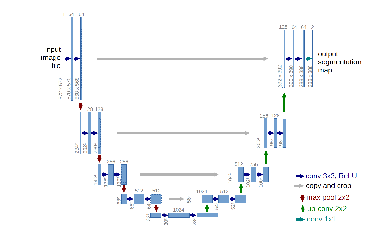

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

print('U-net architecture')
img = mpimg.imread(Path + 'u-net-architecture.png')
plt.axis('off')
imgplot = plt.imshow(img)

In [15]:
model.fit_generator(trainer, steps_per_epoch=50, epochs=30, validation_data=tester, validation_steps=50)

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


50/50 [==============================] - 227s 5s/step - loss: 0.4063 - dice_coef: 0.3628 - val_loss: 0.2568 - val_dice_coef: 0.6022
Epoch 2/30
50/50 [==============================] - 189s 4s/step - loss: 0.2140 - dice_coef: 0.6719 - val_loss: 0.1417 - val_dice_coef: 0.7707
Epoch 3/30
50/50 [==============================] - 172s 3s/step - loss: 0.1488 - dice_coef: 0.7772 - val_loss: 0.1261 - val_dice_coef: 0.7923
Epoch 4/30
50/50 [==============================] - 141s 3s/step - loss: 0.1148 - dice_coef: 0.8295 - val_loss: 0.1064 - val_dice_coef: 0.8447
Epoch 5/30
50/50 [==============================] - 132s 3s/step - loss: 0.1164 - dice_coef: 0.8354 - val_loss: 0.0935 - val_dice_coef: 0.8806
Epoch 6/30
50/50 [==============================] - 120s 2s/step - loss: 0.0932 - dice_coef: 0.8654 - val_loss: 0.1110 - val_dice_coef: 0.8485
Epoch 7/30
50/50 [==============================] - 102s 2s/step - loss: 0.0762 - dice_coef: 0.8896 - val_loss: 0.0730 - val_dice_coef: 0.8860
Epoch 8/30

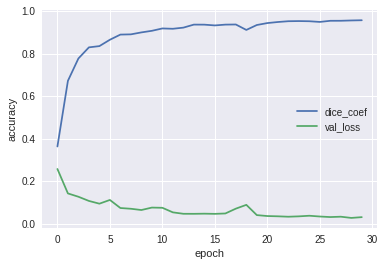

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
def show_history(history):
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['dice_coef', 'val_loss'], loc='best')
    plt.show()

show_history(model.history)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Figure 1:


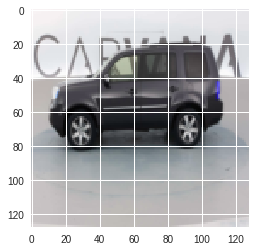

Mask for Figre 1


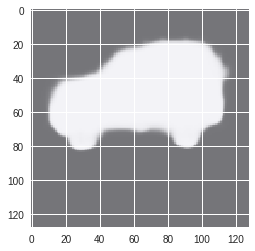

In [28]:
img, msk = next(tester)
predicted_mask = model.predict(img)
#predicted_mask.shape


#Test the car recongnition
#Refresh to see differnt images of the mask and corresponding image
print('Figure 1:')
newshape = img[3].swapaxes(0,2)
plt.imshow(newshape)
plt.show()

print('Mask for Figre 1')
newshape = predicted_mask.swapaxes(1,3)
grey = transform(newshape[3])
plt.imshow(grey, alpha = 0.5)
plt.show()

**Results of Model1:**  The model had a dice coefficient of 95.58% match, which measures the similarities between axis x and y of the photos. As we can see in Figure 1 of Model 1 the mask is a big blurry on the edges and could use some shaping up. 

**New Model2 Attempt** Due to the low score, I add 2 additional convolution layers to this model, keeping everything the same to see if a more complex model will increase the dice coefficient. I hope to avoid overfitting, as a complex model can cause overfitting. The model starts with 32 filters and increasing at an exponetial rate of 2, up to 1024 filters. 

In [40]:
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.optimizers import Adam
from keras import backend as K
K.set_image_dim_ordering('th')

def unet_car_segmentation():
    inputs = Input((3,size[0], size[1]))
    
    level1 = Conv2D(32, (3, 3), padding= "same", activation='relu')(inputs)    
    level1 = Conv2D(32, (3, 3), padding= "same", activation='relu')(level1)
    maxpool1 = MaxPooling2D(pool_size=(2, 2))(level1)

    level2 = Conv2D(64, (3, 3), padding="same", activation='relu')(maxpool1)
    level2 = Conv2D(64, (3, 3), padding="same", activation='relu')(level2)    
    maxpool2 = MaxPooling2D(pool_size=(2, 2))(level2)

    level3 = Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool2)
    level3 = Conv2D(128, (3, 3), padding="same", activation='relu')(level3)
    maxpool3 = MaxPooling2D(pool_size=(2, 2))(level3)

    level4 = Conv2D(256, (3, 3), padding="same", activation='relu')(maxpool3)
    level4 = Conv2D(256, (3, 3), padding="same", activation='relu')(level4)
    maxpool4 = MaxPooling2D(pool_size=(2, 2))(level4)
    
    level5 = Conv2D(512, (3, 3), padding="same", activation='relu')(maxpool4)
    level5 = Conv2D(512, (3, 3), padding="same", activation='relu')(level5)
    maxpool5 = MaxPooling2D(pool_size=(2, 2))(level5)

    level6 = Conv2D(1024, (3, 3), padding="same", activation='relu')(maxpool5)
    level6 = Conv2D(1024, (3, 3), padding="same", activation='relu')(level6)

    upconv7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level6), level5])
    level7 = Conv2D(512, (3, 3), padding="same", activation='relu')(upconv7)
    level7 = Conv2D(512, (3, 3), padding="same", activation='relu')(level7)
   
    upconv8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level7), level4])
    level8 = Conv2D(256, (3, 3), padding="same", activation='relu')(upconv8)
    level8 = Conv2D(256, (3, 3), padding="same", activation='relu')(level8)

    upconv9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level8), level3])
    level9 = Conv2D(128, (3, 3), padding="same", activation='relu')(upconv9)
    level9 = Conv2D(128, (3, 3), padding="same", activation='relu')(level9)

    upconv10 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level9), level2])
    level10 = Conv2D(64, (3, 3), padding="same", activation='relu')(upconv10)
    level10 = Conv2D(64, (3, 3), padding="same", activation='relu')(level10)

    upconv11 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level10), level1])
    level11 = Conv2D(32, (3, 3), padding="same", activation='relu')(upconv11)
    level11 = Conv2D(32, (3, 3), padding="same", activation='relu')(level11)

    level12 = Conv2D(1, (1, 1), activation='sigmoid')(level11)  

    model = Model(inputs=inputs, outputs=level12)

    
    model.compile(optimizer=Adam(.0005), loss='binary_crossentropy', metrics=[dice_coef])

    return model
model = unet_car_segmentation()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 32, 128, 128) 896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 32, 128, 128) 9248        conv2d_87[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 32, 64, 64)   0           conv2d_88[0][0]                  
__________________________________________________________________________________________________
conv2d_89 

In [41]:
model.fit_generator(trainer, steps_per_epoch=50, epochs=30, validation_data=tester, validation_steps=50)

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


50/50 [==============================] - 46s 925ms/step - loss: 0.4054 - dice_coef: 0.3823 - val_loss: 0.1971 - val_dice_coef: 0.7040
Epoch 2/30
50/50 [==============================] - 41s 812ms/step - loss: 0.2169 - dice_coef: 0.6760 - val_loss: 0.1795 - val_dice_coef: 0.6589
Epoch 3/30
50/50 [==============================] - 42s 840ms/step - loss: 0.1464 - dice_coef: 0.7834 - val_loss: 0.1196 - val_dice_coef: 0.8282
Epoch 4/30
50/50 [==============================] - 40s 809ms/step - loss: 0.1168 - dice_coef: 0.8332 - val_loss: 0.1061 - val_dice_coef: 0.8447
Epoch 5/30
50/50 [==============================] - 38s 762ms/step - loss: 0.1077 - dice_coef: 0.8482 - val_loss: 0.0817 - val_dice_coef: 0.8689
Epoch 6/30
50/50 [==============================] - 40s 808ms/step - loss: 0.0831 - dice_coef: 0.8784 - val_loss: 0.0824 - val_dice_coef: 0.8637
Epoch 7/30
50/50 [==============================] - 39s 776ms/step - loss: 0.0760 - dice_coef: 0.8883 - val_loss: 0.0670 - val_dice_coef: 0.8

Dice Coeffecient over epochs


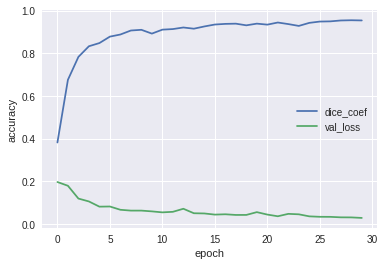

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Figure 1:


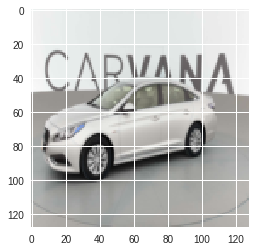

Mask for Figre 1


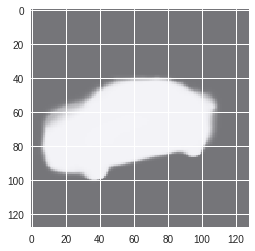

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['dice_coef', 'val_loss'], loc='best')
    plt.show()

print('Dice Coeffecient over epochs')
show_history(model.history)

img, msk = next(tester)
predicted_mask = model.predict(img)
#predicted_mask.shape


#Test the car recongnition
#Refresh to see differnt images of the mask and corresponding image
print('Figure 1:')
newshape = img[3].swapaxes(0,2)
plt.imshow(newshape)
plt.show()

print('Mask for Figre 1')
newshape = predicted_mask.swapaxes(1,3)
grey = transform(newshape[3])
plt.imshow(grey, alpha = 0.5)
plt.show()

**Results of Model2** The additional convolution layers produced the same dice coefficient of 95.58% match. There are similar blurs in the mask along with missed details on the edges. 

 **New Model3 Attempt** With this model I kept the same number of convolutions but changed the learning rate to .001 and added 20 more epochs, for a total of 50 epochs. 

In [45]:
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.optimizers import Adam
from keras import backend as K
K.set_image_dim_ordering('th')

def unet_car_segmentation():
    inputs = Input((3,size[0], size[1]))
    
    level1 = Conv2D(32, (3, 3), padding= "same", activation='relu')(inputs)    
    level1 = Conv2D(32, (3, 3), padding= "same", activation='relu')(level1)
    maxpool1 = MaxPooling2D(pool_size=(2, 2))(level1)

    level2 = Conv2D(64, (3, 3), padding="same", activation='relu')(maxpool1)
    level2 = Conv2D(64, (3, 3), padding="same", activation='relu')(level2)    
    maxpool2 = MaxPooling2D(pool_size=(2, 2))(level2)

    level3 = Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool2)
    level3 = Conv2D(128, (3, 3), padding="same", activation='relu')(level3)
    maxpool3 = MaxPooling2D(pool_size=(2, 2))(level3)

    level4 = Conv2D(256, (3, 3), padding="same", activation='relu')(maxpool3)
    level4 = Conv2D(256, (3, 3), padding="same", activation='relu')(level4)
    maxpool4 = MaxPooling2D(pool_size=(2, 2))(level4)
    
    level5 = Conv2D(512, (3, 3), padding="same", activation='relu')(maxpool4)
    level5 = Conv2D(512, (3, 3), padding="same", activation='relu')(level5)
    maxpool5 = MaxPooling2D(pool_size=(2, 2))(level5)

    level6 = Conv2D(1024, (3, 3), padding="same", activation='relu')(maxpool5)
    level6 = Conv2D(1024, (3, 3), padding="same", activation='relu')(level6)

    upconv7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level6), level5])
    level7 = Conv2D(512, (3, 3), padding="same", activation='relu')(upconv7)
    level7 = Conv2D(512, (3, 3), padding="same", activation='relu')(level7)
   
    upconv8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level7), level4])
    level8 = Conv2D(256, (3, 3), padding="same", activation='relu')(upconv8)
    level8 = Conv2D(256, (3, 3), padding="same", activation='relu')(level8)

    upconv9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level8), level3])
    level9 = Conv2D(128, (3, 3), padding="same", activation='relu')(upconv9)
    level9 = Conv2D(128, (3, 3), padding="same", activation='relu')(level9)

    upconv10 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level9), level2])
    level10 = Conv2D(64, (3, 3), padding="same", activation='relu')(upconv10)
    level10 = Conv2D(64, (3, 3), padding="same", activation='relu')(level10)

    upconv11 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level10), level1])
    level11 = Conv2D(32, (3, 3), padding="same", activation='relu')(upconv11)
    level11 = Conv2D(32, (3, 3), padding="same", activation='relu')(level11)

    level12 = Conv2D(1, (1, 1), activation='sigmoid')(level11)  

    model = Model(inputs=inputs, outputs=level12)

    
    model.compile(optimizer=Adam(.001), loss='binary_crossentropy', metrics=[dice_coef])

    return model
model = unet_car_segmentation()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 32, 128, 128) 896         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_111 (Conv2D)             (None, 32, 128, 128) 9248        conv2d_110[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_29 (MaxPooling2D) (None, 32, 64, 64)   0           conv2d_111[0][0]                 
__________________________________________________________________________________________________
conv2d_112

In [46]:
model.fit_generator(trainer, steps_per_epoch=50, epochs=50, validation_data=tester, validation_steps=50)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


50/50 [==============================] - 40s 804ms/step - loss: 0.3876 - dice_coef: 0.4175 - val_loss: 0.3391 - val_dice_coef: 0.5885
Epoch 2/50
50/50 [==============================] - 36s 713ms/step - loss: 0.4045 - dice_coef: 0.4596 - val_loss: 0.3509 - val_dice_coef: 0.5115
Epoch 3/50
50/50 [==============================] - 36s 721ms/step - loss: 0.2711 - dice_coef: 0.5804 - val_loss: 0.2086 - val_dice_coef: 0.6784
Epoch 4/50
50/50 [==============================] - 36s 719ms/step - loss: 0.2020 - dice_coef: 0.7055 - val_loss: 0.2363 - val_dice_coef: 0.6646
Epoch 5/50
50/50 [==============================] - 34s 671ms/step - loss: 0.1370 - dice_coef: 0.7946 - val_loss: 0.1426 - val_dice_coef: 0.8037
Epoch 6/50
50/50 [==============================] - 36s 721ms/step - loss: 0.1318 - dice_coef: 0.8166 - val_loss: 0.1226 - val_dice_coef: 0.8237
Epoch 7/50
50/50 [==============================] - 36s 725ms/step - loss: 0.1206 - dice_coef: 0.8183 - val_loss: 0.1105 - val_dice_coef: 0.8

Dice Coeffecient over epochs


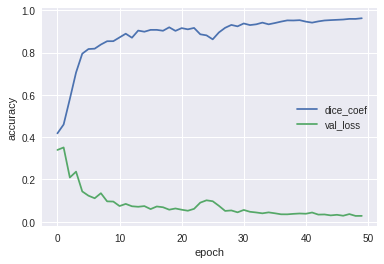

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Figure 1:


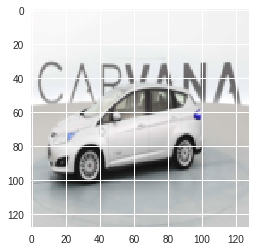

Mask for Figre 1


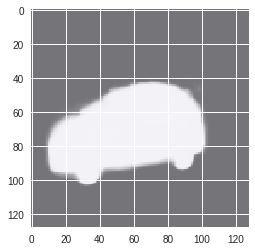

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['dice_coef', 'val_loss'], loc='best')
    plt.show()

print('Dice Coeffecient over epochs')
show_history(model.history)

img, msk = next(tester)
predicted_mask = model.predict(img)
#predicted_mask.shape


#Test the car recongnition
#Refresh to see differnt images of the mask and corresponding image
print('Figure 1:')
newshape = img[3].swapaxes(0,2)
plt.imshow(newshape)
plt.show()

print('Mask for Figre 1')
newshape = predicted_mask.swapaxes(1,3)
grey = transform(newshape[3])
plt.imshow(grey, alpha = 0.5)
plt.show()

**Results of Model3** The new model performed at a 96.14% match. We can see some of the blurriness be removed with the additional .56% increase. The edges are becoming more deatiled as well. The dice coefficient had a local minium around the 25th epoch dropping about 6% of the total, however, the dice coefficient did increase again leading to the higher match percentage. 

**New Model4 Attempt** In this model i decided to reduce the number of convoloution layers to relieve the model of any possible overfitting for better generalization. There are a totoal of 8 convolution layers starting  at 32 filters and increasing by an exponetial figure of 2 ending at 256. In addition I lowered the learning rate to .01 and decreased the number of epochs to 35. 

In [54]:
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.optimizers import Adam
from keras import backend as K
K.set_image_dim_ordering('th')

def unet_car_segmentation():
    inputs = Input((3,size[0], size[1]))
    
    level1 = Conv2D(32, (3, 3), padding= "same", activation='relu')(inputs)    
    level1 = Conv2D(32, (3, 3), padding= "same", activation='relu')(level1)
    maxpool1 = MaxPooling2D(pool_size=(2, 2))(level1)

    level2 = Conv2D(64, (3, 3), padding="same", activation='relu')(maxpool1)
    level2 = Conv2D(64, (3, 3), padding="same", activation='relu')(level2)    
    maxpool2 = MaxPooling2D(pool_size=(2, 2))(level2)

    level3 = Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool2)
    level3 = Conv2D(128, (3, 3), padding="same", activation='relu')(level3)
    maxpool3 = MaxPooling2D(pool_size=(2, 2))(level3)

    level4 = Conv2D(256, (3, 3), padding="same", activation='relu')(maxpool3)
    level4 = Conv2D(256, (3, 3), padding="same", activation='relu')(level4)

    upconv5 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level4), level3])
    level5 = Conv2D(128, (3, 3), padding="same", activation='relu')(upconv5)
    level5 = Conv2D(128, (3, 3), padding="same", activation='relu')(level5)

    upconv6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level5), level2])
    level6 = Conv2D(64, (3, 3), padding="same", activation='relu')(upconv6)
    level6 = Conv2D(64, (3, 3), padding="same", activation='relu')(level6)

    upconv7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(level6), level1])
    level7 = Conv2D(32, (3, 3), padding="same", activation='relu')(upconv7)
    level7 = Conv2D(32, (3, 3), padding="same", activation='relu')(level7)

    level8 = Conv2D(1, (1, 1), activation='sigmoid')(level7)  

    model = Model(inputs=inputs, outputs=level8)

    
    model.compile(optimizer=Adam(.01), loss='binary_crossentropy', metrics=[dice_coef])

    return model
model = unet_car_segmentation()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 32, 128, 128) 896         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 32, 128, 128) 9248        conv2d_133[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_34 (MaxPooling2D) (None, 32, 64, 64)   0           conv2d_134[0][0]                 
__________________________________________________________________________________________________
conv2d_135

In [55]:
model.fit_generator(trainer, steps_per_epoch=50, epochs=35, validation_data=tester, validation_steps=50)

Epoch 1/35


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


50/50 [==============================] - 36s 716ms/step - loss: 0.4412 - dice_coef: 0.3547 - val_loss: 0.4035 - val_dice_coef: 0.6169
Epoch 2/35
50/50 [==============================] - 31s 621ms/step - loss: 0.2700 - dice_coef: 0.5846 - val_loss: 0.2009 - val_dice_coef: 0.6416
Epoch 3/35
50/50 [==============================] - 32s 645ms/step - loss: 0.1732 - dice_coef: 0.7432 - val_loss: 0.1392 - val_dice_coef: 0.8156
Epoch 4/35
50/50 [==============================] - 31s 616ms/step - loss: 0.1459 - dice_coef: 0.7746 - val_loss: 0.1210 - val_dice_coef: 0.8254
Epoch 5/35
50/50 [==============================] - 31s 617ms/step - loss: 0.1121 - dice_coef: 0.8375 - val_loss: 0.1026 - val_dice_coef: 0.8466
Epoch 6/35
50/50 [==============================] - 30s 604ms/step - loss: 0.1037 - dice_coef: 0.8459 - val_loss: 0.0995 - val_dice_coef: 0.8712
Epoch 7/35
50/50 [==============================] - 31s 622ms/step - loss: 0.0937 - dice_coef: 0.8647 - val_loss: 0.1003 - val_dice_coef: 0.8

Dice Coeffecient over epochs


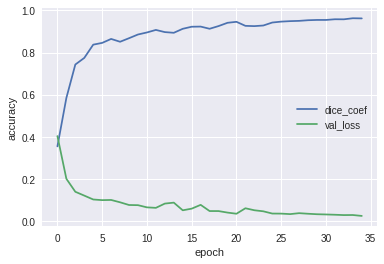

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Figure 1:


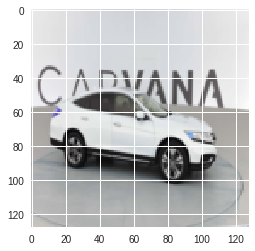

Mask for Figre 1


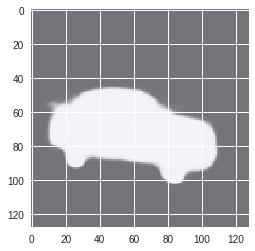

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['dice_coef', 'val_loss'], loc='best')
    plt.show()

print('Dice Coeffecient over epochs')
show_history(model.history)

img, msk = next(tester)
predicted_mask = model.predict(img)
#predicted_mask.shape


#Test the car recongnition
#Refresh to see differnt images of the mask and corresponding image
print('Figure 1:')
newshape = img[3].swapaxes(0,2)
plt.imshow(newshape)
plt.show()

print('Mask for Figre 1')
newshape = predicted_mask.swapaxes(1,3)
grey = transform(newshape[3])
plt.imshow(grey, alpha = 0.5)
plt.show()

**Results of Model4** To my surpise, this model has increased its matching percentage to 96.49%. This model had no critical dips in the training as well. The mask appears to be more defined on the edges from an increase of .34%, but can still see blemishes in the details.